In [1]:
# notebook settings
%load_ext autoreload
%autoreload 2

# external imports
import numpy as np
import sympy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import copy
from math import floor

# internal imports
from pympc.geometry.polyhedron import Polyhedron
from pympc.dynamics.discrete_time_systems import LinearSystem, AffineSystem, PieceWiseAffineSystem
from pympc.control.hybrid_benchmark.controllers import HybridModelPredictiveController
from pympc.plot import plot_input_sequence, plot_state_trajectory, plot_output_trajectory
from pympc.control.hybrid_benchmark.utils import get_constraint_set, remove_redundant_inequalities_fast, convex_hull_method_fast

# Problem set-up

In [2]:
# numeric parameters of the system
m = 1.
r = .1
I = .4*m*r**2.
d = .4
l = .3
mu = .2
g = 10.
h = .05

In [3]:
# symbolic state
xb, yb, tb = sp.symbols('xb yb tb') # position of the ball
xf, yf = sp.symbols('xf yf') # position of the floor
xdb, ydb, tdb = sp.symbols('xdb ydb tdb') # velocity of the ball
xdf, ydf = sp.symbols('xdf ydf') # velocity of the floor
x = sp.Matrix([
    xb, yb, tb,
    xf, yf,
    xdb, ydb, tdb,
    xdf, ydf
])

# symbolic input
xd2f, yd2f = sp.symbols('xd2f yd2f') # acceleration of the floor
u = sp.Matrix([
    xd2f, yd2f
])

# contact forces
ftf, fnf = sp.symbols('ftf fnf') # floor force
ftc, fnc = sp.symbols('ftc fnc') # ceiling force

In [4]:
# ball velocity update
xdb_next = xdb + h*ftf/m - h*ftc/m
ydb_next = ydb + h*fnf/m - h*fnc/m - h*g
tdb_next = tdb + r*h*ftf/I + r*h*ftc/I

# ball position update
xb_next = xb + h*xdb_next
yb_next = yb + h*ydb_next
tb_next = tb + h*tdb_next

# floor velocity update
xdf_next = xdf + h*xd2f
ydf_next = ydf + h*yd2f

# floor position update
xf_next = xf + h*xdf_next
yf_next = yf + h*ydf_next

# state update
x_next = sp.Matrix([
    xb_next, yb_next, tb_next,
    xf_next, yf_next,
    xdb_next, ydb_next, tdb_next,
    xdf_next, ydf_next
])

In [5]:
# relative tangential velocity
sliding_velocity_floor = xdb_next + r*tdb_next - xdf_next
sliding_velocity_ceiling = xdb_next - r*tdb_next

# gap function floor
gap_floor = yb_next - yf_next

# gap function ceiling
gap_ceiling = d - 2.*r - yb_next

# ball distance to boundaries
ball_on_floor = sp.Matrix([
    xb_next - xf_next - l,
    xf_next - xb_next - l
])
ball_on_ceiling = sp.Matrix([
    xb_next - l,
    - xb_next - l
])

In [6]:
# state bounds
x_max = np.array([
    l, d-2.*r, 1.2*np.pi, # ball config
    l, d-2.*r-.05,            # floor config
    2., 2., 10.,     # ball vel
    2., 2.          # floor vel
])
x_min = - x_max

# input bounds
u_max = np.array([
    30., 30.,          # floor acc
])
u_min = - u_max

# domain bounds
xu = x.col_join(u)
xu_min = np.concatenate((x_min, u_min))
xu_max = np.concatenate((x_max, u_max))

In [7]:
# discrete time dynamics in mode 1
# (ball in the air)

# set forces to zero
f_m1 = {ftf: 0., fnf: 0., ftc: 0., fnc: 0.}

# get dynamics
x_next_m1 = x_next.subs(f_m1)
S1 = AffineSystem.from_symbolic(x, u, x_next_m1)

# build domain
D1 = Polyhedron.from_bounds(xu_min, xu_max)

# - gap <= 0 with floor and ceiling
gap_floor_m1 = gap_floor.subs(f_m1)
gap_ceiling_m1 = gap_ceiling.subs(f_m1)
D1.add_symbolic_inequality(xu, sp.Matrix([- gap_floor_m1]))
D1.add_symbolic_inequality(xu, sp.Matrix([- gap_ceiling_m1]))

# check domain
assert D1.bounded
assert not D1.empty

In [8]:
# discrete time dynamics in mode 2
# (ball sticking with the floor, not in contact with the ceiling)

# enforce sticking
fc_m2 = {ftc: 0., fnc: 0.}
ftf_m2 = sp.solve(sp.Eq(sliding_velocity_floor.subs(fc_m2), 0), ftf)[0]
fnf_m2 = sp.solve(sp.Eq(gap_floor.subs(fc_m2), 0), fnf)[0]
f_m2 = fc_m2.copy()
f_m2.update({ftf: ftf_m2, fnf: fnf_m2})

# get dynamics
x_next_m2 = x_next.subs(f_m2)
S2 = AffineSystem.from_symbolic(x, u, x_next_m2)

# build domain
D2 = Polyhedron.from_bounds(xu_min, xu_max)

# gap <= 0 with floor
D2.add_symbolic_inequality(xu, sp.Matrix([gap_floor_m1]))

# - gap <= 0 with ceiling
D2.add_symbolic_inequality(xu, sp.Matrix([- gap_ceiling_m1]))

# ball not falling down the floor
D2.add_symbolic_inequality(xu, ball_on_floor.subs(f_m2))

# friction cone
D2.add_symbolic_inequality(xu, sp.Matrix([ftf_m2 - mu*fnf_m2]))
D2.add_symbolic_inequality(xu, sp.Matrix([- ftf_m2 - mu*fnf_m2]))

# check domain
assert D2.bounded
assert not D2.empty

In [9]:
# discrete time dynamics in mode 3
# (ball sliding right on the floor, not in contact with the ceiling)

# enforce sticking
f_m3 = {ftf: -mu*fnf_m2, fnf: fnf_m2, ftc: 0., fnc: 0.}

# get dynamics
x_next_m3 = x_next.subs(f_m3)
S3 = AffineSystem.from_symbolic(x, u, x_next_m3)

# build domain
D3 = Polyhedron.from_bounds(xu_min, xu_max)

# gap <= 0 with floor
D3.add_symbolic_inequality(xu, sp.Matrix([gap_floor_m1]))

# - gap <= 0 with ceiling
D3.add_symbolic_inequality(xu, sp.Matrix([- gap_ceiling_m1]))

# ball not falling down the floor
D3.add_symbolic_inequality(xu, ball_on_floor.subs(f_m3))

# positive relative velocity
D3.add_symbolic_inequality(xu, sp.Matrix([- sliding_velocity_floor.subs(f_m3)]))

# check domain
assert D3.bounded
assert not D3.empty

In [10]:
# discrete time dynamics in mode 4
# (ball sliding left on the floor, not in contact with the ceiling)

# enforce sticking
f_m4 = {ftf: mu*fnf_m2, fnf: fnf_m2, ftc: 0., fnc: 0.}

# get dynamics
x_next_m4 = x_next.subs(f_m4)
S4 = AffineSystem.from_symbolic(x, u, x_next_m4)

# build domain
D4 = Polyhedron.from_bounds(xu_min, xu_max)

# gap <= 0 with floor
D4.add_symbolic_inequality(xu, sp.Matrix([gap_floor_m1]))

# - gap <= 0 with ceiling
D4.add_symbolic_inequality(xu, sp.Matrix([- gap_ceiling_m1]))

# ball not falling down the floor
D4.add_symbolic_inequality(xu, ball_on_floor.subs(f_m4))

# negative relative velocity
D4.add_symbolic_inequality(xu, sp.Matrix([sliding_velocity_floor.subs(f_m4)]))

# check domain
assert D4.bounded
assert not D4.empty

In [11]:
# discrete time dynamics in mode 5
# (ball sticking on the ceiling, not in contact with the floor)

# enforce sticking
ff_m5 = {ftf: 0., fnf: 0.}
ftc_m5 = sp.solve(sp.Eq(sliding_velocity_ceiling.subs(ff_m5), 0), ftc)[0]
fnc_m5 = sp.solve(sp.Eq(gap_ceiling.subs(ff_m5), 0), fnc)[0]
f_m5 = ff_m5.copy()
f_m5.update({ftc: ftc_m5, fnc: fnc_m5})

# get dynamics
x_next_m5 = x_next.subs(f_m5)
S5 = AffineSystem.from_symbolic(x, u, x_next_m5)

# build domain
D5 = Polyhedron.from_bounds(xu_min, xu_max)

# - gap <= 0 with floor
D5.add_symbolic_inequality(xu, sp.Matrix([- gap_floor_m1]))

# gap <= 0 with ceiling
D5.add_symbolic_inequality(xu, sp.Matrix([gap_ceiling_m1]))

# ball in contact with the ceiling
D5.add_symbolic_inequality(xu, ball_on_ceiling.subs(f_m5))

# friction cone
D5.add_symbolic_inequality(xu, sp.Matrix([ftc_m5 - mu*fnc_m5]))
D5.add_symbolic_inequality(xu, sp.Matrix([- ftc_m5 - mu*fnc_m5]))

# check domain
assert D5.bounded
assert not D5.empty

In [12]:
# discrete time dynamics in mode 6
# (ball sliding right on the ceiling, not in contact with the floor)


# enforce sticking
f_m6 = {ftc: -mu*fnc_m5, fnc: fnc_m5, ftf: 0., fnf: 0.}

# get dynamics
x_next_m6 = x_next.subs(f_m6)
S6 = AffineSystem.from_symbolic(x, u, x_next_m6)

# build domain
D6 = Polyhedron.from_bounds(xu_min, xu_max)

# - gap <= 0 with floor
D6.add_symbolic_inequality(xu, sp.Matrix([- gap_floor_m1]))

# gap <= 0 with ceiling
D6.add_symbolic_inequality(xu, sp.Matrix([gap_ceiling_m1]))

# ball in contact with the ceiling
D6.add_symbolic_inequality(xu, ball_on_ceiling.subs(f_m6))

# positive relative velocity
D6.add_symbolic_inequality(xu, sp.Matrix([- sliding_velocity_ceiling.subs(f_m6)]))

# check domain
assert D6.bounded
assert not D6.empty

In [13]:
# discrete time dynamics in mode 7
# (ball sliding left on the ceiling, not in contact with the floor)

# enforce sticking
f_m7 = {ftc: mu*fnc_m5, fnc: fnc_m5, ftf: 0., fnf: 0.}

# get dynamics
x_next_m7 = x_next.subs(f_m7)
S7 = AffineSystem.from_symbolic(x, u, x_next_m7)

# build domain
D7 = Polyhedron.from_bounds(xu_min, xu_max)

# - gap <= 0 with floor
D7.add_symbolic_inequality(xu, sp.Matrix([- gap_floor_m1]))

# gap <= 0 with ceiling
D7.add_symbolic_inequality(xu, sp.Matrix([gap_ceiling_m1]))

# ball in contact with the ceiling
D7.add_symbolic_inequality(xu, ball_on_ceiling.subs(f_m7))

# negative relative velocity
D7.add_symbolic_inequality(xu, sp.Matrix([sliding_velocity_ceiling.subs(f_m7)]))

# check domain
assert D7.bounded
assert not D7.empty

In [14]:
# list of dynamics
S_list = [S1, S2, S3, S4, S5, S6, S7]

# list of domains
D_list = [D1, D2, D3, D4, D5, D6, D7]

# PWA system
S = PieceWiseAffineSystem(S_list, D_list)

In [15]:
# controller parameters
N = 20
Q = np.diag([
    1., 1., .01,
    1., 1.,
    1., 1., .01,
    1., 1.
])*2.
R = np.diag([
    .01, .001
])*2.
P = np.zeros((S.nx, S.nx))

# terminal set and cost
X_N = Polyhedron.from_bounds(*[np.zeros(S.nx)]*2)

In [16]:
methods = ['PF', 'CH', 'BM', 'MLD']
norms = ['inf', 'one', 'two']

# Comparison of the different formulations

In [ ]:
# initial condition
x0 = np.array([
    0., 0., np.pi,
    0., 0.,
    0., 0., 0.,
    0., 0.
])

In [ ]:
# solve MICP with all the methods (takes hours!)
solves = {}
for norm in norms:
    print '\nnorm:', norm
    solves[norm] = {}
    for method in methods:
        print '\nmethod:', method
        controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method, norm)
        controller.prog.setParam('TimeLimit', 3600)
        u_mip, x_mip, ms_mip, cost_mip = controller.feedforward(x0)
        solves[norm][method] = {
            'time': controller.prog.Runtime,
            'nodes': controller.prog.NodeCount,
            'mip_gap': controller.prog.MIPGap,
            'u': u_mip,
            'x': x_mip,
            'ms': ms_mip,
            'cost': cost_mip
        }
# np.save('data_mip_formulations/flip_benchmark', solves)

In [ ]:
# loads the results above and prints the results
solves = np.load('data_mip_formulations/flip_benchmark.npy').item()
for norm in norms:
    print '\nnorm:', norm
    for method in methods:
        print '\nmethod:', method
        print 'mip gap:', solves[norm][method]['mip_gap']
        print 'time:', solves[norm][method]['time']
        print 'nodes:', solves[norm][method]['nodes']

# Animation

In [ ]:
import meshcat
from meshcat.geometry import Box, Sphere, Cylinder, MeshLambertMaterial
from meshcat.animation import Animation
import meshcat.transformations as tf

In [ ]:
solves = np.load('data_mip_formulations/flip_benchmark.npy').item()

In [ ]:
vis = meshcat.Visualizer()
# vis.jupyter_cell()
vis.open()

In [ ]:
tickness = .01
depth = .3
red = 0xff2222
blue = 0x2222ff
green = 0x22ff22
grey = 0x999999
vis['ball'].set_object(
    Sphere(r),
    MeshLambertMaterial(color=blue)
)
vis['floor'].set_object(
    Box([depth, l*2., tickness]),
    MeshLambertMaterial(color=red)
)
vis['ceiling'].set_object(
    Box([depth, l*2., tickness]),
    MeshLambertMaterial(color=grey)
)
vis['ball_orientation'].set_object(
    Cylinder(r/10., r*1.002),
    MeshLambertMaterial(color=green)
)

In [ ]:
anim = Animation()
for t, xt in enumerate(solves['inf']['CH']['x']):
    with anim.at_frame(vis, t*h*30) as frame:
        frame['ball'].set_transform(
            tf.translation_matrix([0, xt[0], xt[1]+r])
        )
        frame['floor'].set_transform(
            tf.translation_matrix([0, xt[3], xt[4]-tickness/2.])
        )
        frame['ceiling'].set_transform(
            tf.translation_matrix([0, 0, d+tickness/2.])
        )
        frame['ball_orientation'].set_transform(
            tf.translation_matrix([0, xt[0], xt[1]+r]).dot(
                tf.rotation_matrix(xt[2], [1.,0.,0.])
            )
        )
vis.set_animation(anim)

# Compare formulations for different levels of relaxation

In [ ]:
# cost of each relaxation as a function of time (takes approx. 1 minute)
solves = np.load('data_mip_formulations/flip_benchmark.npy').item()
costs = {}
for norm in norms:
    print 'norm', norm
    costs[norm] = {}
    for method in methods:
        print 'method', method
        controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method, norm)
        costs[norm][method] = []
        for ms in [solves[norm]['CH']['ms'][:i] for i in range(N+1)]:
            cost = controller.solve_relaxation(x0, ms)[1]
            if cost is not None:
                cost /= solves[norm]['CH']['cost']
            costs[norm][method].append(cost)

In [ ]:
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
for norm in norms:
    mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
    plt.rc('font', size=14)
    colors = ['b', 'r', 'c','g']
    linestyles = ['-', '-.', '--', ':']
    for i, method in enumerate(methods):
        plt.plot(
            range(N+1),
            costs[norm][method],
            label=method,
            color=colors[i],
            linestyle=linestyles[i],
            linewidth=3
        )
    plt.xlim((0, N))
    plt.ylim((0, 1.1))
    plt.legend(loc=4)
    plt.grid(True)
    if norm == 'inf':
        plt.title(r'Linear objective, $\infty$-norm')
    elif norm == 'one':
        plt.title(r'Linear objective, 1-norm')
    elif norm == 'two':
        plt.title(r'Quadratic objective')
    plt.xticks(np.linspace(0,N,11))
    plt.xlabel(r'Time step $t$')
    plt.ylabel(r'Cost relaxed problem / cost MICP')
#     plt.savefig('relaxation_ratio_' + norm + '.pdf', bbox_inches='tight')
    plt.show()

# Objective as a function of the initial state ($x_1$ and $x_3$ only)

In [ ]:
# solve relaxations for all MI formulations (takes time!)
n_samples = 51
xb_samples = np.linspace(0., x_max[0], n_samples)
tb_samples = np.linspace(-np.pi, np.pi, n_samples)
cost = {'xb_samples': xb_samples, 'tb_samples':tb_samples}
for norm in norms:
    print 'norm:', norm
    cost[norm] = {}
    for method in methods:
        print 'method:', method
        controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method, norm)
        cost_mat = np.empty([n_samples]*2)
        for i, xb in enumerate(xb_samples):
            for j, tb in enumerate(tb_samples):
                print(str(i) + ',' + str(j) + '   \r'),
                x0 = np.array([xb,0.,tb] + [0.]*7)
                cost_mat[i,j] = controller.solve_relaxation(x0, {})[1]
        cost[norm][method] = cost_mat

# save data
# np.save('cost_relaxation_different_intial_conditions', cost)

In [ ]:
# plot cost and feasible set
plt.rc('font', size=18)
def my_round(x):
    return floor(x*10.)/10.
n_levels = 10
cost = np.load('data_mip_formulations/cost_relaxation_different_intial_conditions.npy').item()
xb_samples = cost['xb_samples']
tb_samples = cost['tb_samples']
Xb, Tb = np.meshgrid(xb_samples, tb_samples)
for norm in norms:
    print 'norm', norm
    for method in methods:
        plt.figure(figsize=(3.5, 3.))
        print 'method', method
        cm = cost[norm][method]
        levels = [my_round((i+1)*np.nanmax(cm)/n_levels) for i in range(n_levels)]
        levels = [(i+1)*np.nanmax(cm)/n_levels for i in range(n_levels)]
        cp = plt.contour(Xb, Tb, cm.T, levels=levels, cmap='viridis_r')
        cb = plt.colorbar(cp, orientation='horizontal')
        cb.set_ticks([cb.locator()[0],cb.locator()[-1]])
#         cb.ax.set_yticklabels(ticks)
        plt.xticks([0.,.1,.2,.3])
        plt.yticks([-3.,-1.5,0.,1.5,3.])
        plt.grid(True)
        plt.savefig('cost_' + method + '_' + norm + '.pdf',bbox_inches='tight')
        plt.show()

In [ ]:
# samples of the MICP optimal value (takes days!)
n_samples = 11
xb_samples = np.linspace(0., x_max[0], n_samples)
tb_samples = np.linspace(-np.pi, np.pi, n_samples)
cost = {'xb_samples': xb_samples, 'tb_samples':tb_samples}
for norm in norms:
    print '\nnorm:', norm
    controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, 'Convex hull', norm)
    controller.prog.setParam('TimeLimit', 18000)
    cost_mat = np.empty([n_samples]*2)
    for i, xb in enumerate(xb_samples):
        for j, tb in enumerate(tb_samples):
            print i, j
            x0 = np.array([xb,0.,tb] + [0.]*7)
            cost_mat[i,j] = controller.feedforward(x0)[3]
    cost[norm] = cost_mat

# save data
# np.save('cost_varying_position_and_angle_mip_11_samples', cost)

In [ ]:
# plot cost and feasible set
plt.rc('font', size=18)
def my_round(x):
    return floor(x*10.)/10.
n_levels = 10
cost = np.load('data_mip_formulations/cost_micp_different_intial_conditions.npy').item()
xb_samples = cost['xb_samples']
tb_samples = cost['tb_samples']
hor = np.concatenate([[i]*n_samples for i in xb_samples])
ver = tb_samples.tolist()*n_samples
cm = plt.cm.get_cmap('viridis_r')
for norm in norms:
    plt.figure(figsize=(3.5, 3))
    print 'norm', norm
    c = cost[norm].flatten()
    sc = plt.scatter(hor, ver, c=c, cmap=cm)
    cb = plt.colorbar(sc, orientation='horizontal')
    cb.set_ticks([min(c), max(c)])
    plt.xticks([0.,.1,.2,.3])
    plt.yticks([-3.,-1.5,0.,1.5,3.])
    plt.grid(True)
    plt.gca().set_axisbelow(True)
    plt.xlim(-.01,.31)
    plt.ylim(-np.pi-.3,np.pi+.3)
    plt.savefig('cost_mip_' + norm + '.pdf',bbox_inches='tight')
    plt.show()

# Plot optimal mode sequence

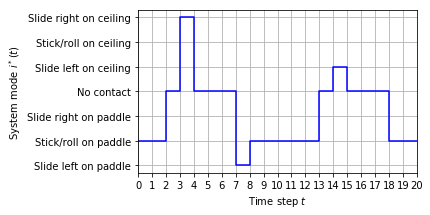

In [19]:
solves = np.load('data_mip_formulations/flip_benchmark.npy').item()
ms = [solves['inf']['CH']['ms'][0]] + solves['inf']['CH']['ms']
ms_map = {0: 3, 1: 1, 2: 2, 3: 0, 4: 5, 5: 6, 6: 4}
ms_legend = [
    '',
    'Slide left on paddle',
    'Stick/roll on paddle',
    'Slide right on paddle',
    'No contact',
    'Slide left on ceiling',
    'Stick/roll on ceiling',
    'Slide right on ceiling'
]
plt.figure(figsize=(5,3))
plt.step(range(N+1), [ms_map[m] for m in ms], color='b')
plt.xticks(range(N+1))
plt.xlim(0, N)
plt.grid(True)
plt.xlabel(r'Time step $t$')
plt.ylabel(r'System mode $i^*(t)$')
plt.gca().set_yticklabels(ms_legend)
plt.savefig('optimal_mode_sequence.pdf',bbox_inches='tight')